In [88]:
import math
import os

import numpy as np
import pandas as pd
import screed
from orpheum import sequence_encodings
from tqdm import tqdm
import seaborn as sns

In [14]:
sequence_encodings.DAYHOFF_MAPPING

{'C': 'a',
 'A': 'b',
 'G': 'b',
 'P': 'b',
 'S': 'b',
 'T': 'b',
 'D': 'c',
 'E': 'c',
 'N': 'c',
 'Q': 'c',
 'H': 'd',
 'K': 'd',
 'R': 'd',
 'I': 'e',
 'L': 'e',
 'M': 'e',
 'V': 'e',
 'F': 'f',
 'W': 'f',
 'Y': 'f'}

In [10]:
from orpheum import compare_kmer_content

In [1]:
# compare_kmer_content.

In [ ]:
from orpheum.compare_kmer_content

In [5]:
swissprot_reviewed = os.path.join(
    "/Users/olgabot/botryllus/data/uniprot/2022-04-16/",
    "uniprot-reviewed_yes+taxonomy_33208_reviewed_only_swissprot.fasta.gz",
)

In [70]:
sequence_encodings.HP_MAPPING

{'A': 'h',
 'F': 'h',
 'G': 'h',
 'I': 'h',
 'L': 'h',
 'M': 'h',
 'P': 'h',
 'V': 'h',
 'W': 'h',
 'Y': 'h',
 'C': 'p',
 'D': 'p',
 'E': 'p',
 'H': 'p',
 'K': 'p',
 'N': 'p',
 'Q': 'p',
 'R': 'p',
 'S': 'p',
 'T': 'p'}

## Add  `B` and `Z` amino acids

In [74]:
dayhoff_mapping = {'C': 'a',
 'A': 'b',
 'G': 'b',
 'P': 'b',
 'S': 'b',
 'T': 'b',
 'D': 'c',
 'E': 'c',
 'N': 'c',
 'Q': 'c',
 'H': 'd',
 'K': 'd',
 'R': 'd',
 'I': 'e',
 'L': 'e',
 'M': 'e',
 'V': 'e',
 'F': 'f',
 'W': 'f',
 'Y': 'f',
                  'Z': 'c', 'B': 'c'}

hp_mapping = {'A': 'h',
 'F': 'h',
 'G': 'h',
 'I': 'h',
 'L': 'h',
 'M': 'h',
 'P': 'h',
 'V': 'h',
 'W': 'h',
 'Y': 'h',
 'C': 'p',
 'D': 'p',
 'E': 'p',
 'H': 'p',
 'K': 'p',
 'N': 'p',
 'Q': 'p',
 'R': 'p',
 'S': 'p',
 'T': 'p', 'Z': 'p', 'B': 'p'}

In [75]:
alphabet_ksizes = {"hp": 24, "dayhoff": 17}

n_kmers_original = []
n_kmers_dayhoff = []
n_kmers_hp = []


def make_reverse_mapping_lengths(alphabet_mapping):
    s = pd.Series(alphabet_mapping)
    reverse_mapping = s.groupby(s).groups
    reverse_mapping_lengths = {k: len(v) for k, v in reverse_mapping.items()}
    return reverse_mapping_lengths


alphabet_mappings = {
    "hp": hp_mapping,
    "dayhoff": dayhoff_mapping,
}

reverse_mappings_lengths = {
    k: make_reverse_mapping_lengths(v) for k, v in alphabet_mappings.items()
}
reverse_mappings_lengths

{'hp': {'h': 10, 'p': 12},
 'dayhoff': {'a': 1, 'b': 5, 'c': 6, 'd': 3, 'e': 4, 'f': 3}}

In [78]:
n_kmers = {'original':[], 'hp': [], 'dayhoff': []}

def count_implicit_synonyms(encoded_peptide, reverse_mapping_lengths):
    n_possible_amino_acids = []
    for letter in encoded_peptide:
        n_possible_amino_acids.append(reverse_mapping_lengths[letter])
    # print(n_possible_amino_acids)
    return math.prod(n_possible_amino_acids)

with screed.open(swissprot_reviewed) as records:
    for i, record in tqdm(enumerate(records)):
        kmers = compare_kmer_content.kmerize(record.sequence, ksize=17)
        n_kmers['original'].append(len(kmers))
        
        for alphabet, ksize in alphabet_ksizes.items():
            n_kmers[alphabet].append(0)
            reverse_mapping = reverse_mappings_lengths[alphabet]
            for kmer in kmers:
                try:
                    encoded = sequence_encodings.encode_peptide(kmer, alphabet)
                    n_synonyms = count_implicit_synonyms(encoded, reverse_mapping)
                    n_kmers[alphabet][i] += n_synonyms
                except KeyError:
                    # E.g. B or Z amino acids
                    continue

            




108571it [04:15, 425.21it/s]


In [79]:
n_kmers_df = pd.DataFrame(n_kmers)
n_kmers_df.head()

,original,hp,dayhoff
0,259,124314353091477504000,13620937155840
1,207,114246756968693760000,27181480677660
2,58,19412369031168000000,1820774437500
3,58,21954070020096000000,1720440102000
4,489,213837660855336960000,33101732103840


In [86]:
n_kmers_df["hp_degeneracy_rate"] = n_kmers_df.hp / n_kmers_df.original.replace(
    0, np.nan
)
n_kmers_df["dayhoff_degeneracy_rate"] = n_kmers_df.dayhoff / n_kmers_df.original.replace(
    0, np.nan
)

n_kmers_df.head()

,original,hp,dayhoff,hp_degeneracy_rate,dayhoff_degeneracy_rate
0,259,124314353091477504000,13620937155840,479978197264391936.0,5.259049e+10
1,207,114246756968693760000,27181480677660,551916700331853888.0,1.313115e+11
2,58,19412369031168000000,1820774437500,334696017778758592.0,3.139266e+10
3,58,21954070020096000000,1720440102000,378518448622344832.0,2.966276e+10
4,489,213837660855336960000,33101732103840,437295829970014208.0,6.769270e+10


/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


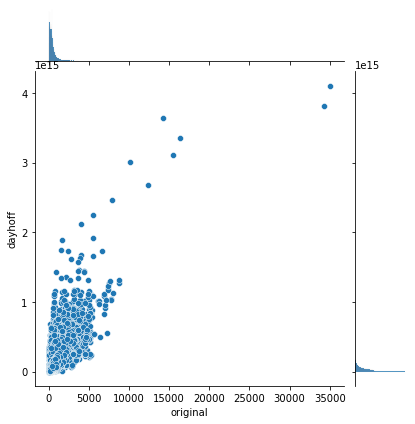

In [100]:
sns.jointplot('original', 'dayhoff', n_kmers_df)

In [98]:
# n_kmers_df.sum().astype(int)

In [101]:
n_kmers_df.sum()

original                                     46182346
hp                         23874777716724470927851520
dayhoff                           6188296889534038455
hp_degeneracy_rate          54318876842853606096896.0
dayhoff_degeneracy_rate           12605791229363594.0
dtype: object

In [102]:
n_kmers_df.mean()

original                   4.253654e+02
hp                         2.199001e+20
dayhoff                    5.699770e+13
hp_degeneracy_rate         5.100843e+17
dayhoff_degeneracy_rate    1.183754e+11
dtype: float64

In [92]:
np.log10(n_kmers_df.sum().values)

TypeError: loop of ufunc does not support argument 0 of type numpy.int64 which has no callable log10 method

In [87]:
n_kmers_df.describe()

,original,dayhoff,dayhoff_degeneracy_rate
count,108571.000000,1.085710e+05,1.064900e+05
mean,425.365392,5.699770e+13,1.183754e+11
std,477.707599,9.144389e+13,1.205618e+11
min,0.000000,0.000000e+00,0.000000e+00
25%,156.000000,1.228513e+13,6.459993e+10
50%,326.000000,3.015174e+13,9.462059e+10
75%,527.000000,6.568183e+13,1.417571e+11
max,35018.000000,4.103558e+15,1.410555e+13


In [ ]:
n_kmers[alphabet]

In [62]:
n_synonyms

100000000000000000

In [15]:
sequence_encodings.reencode??

Signature: sequence_encodings.reencode(peptide_sequence, molecule)
Docstring: <no docstring>
Source:   
def reencode(peptide_sequence, molecule):
    translator = PEPTIDE_ENCODINGS[molecule]
    return peptide_sequence.translate(translator)
File:      ~/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/orpheum/sequence_encodings.py
Type:      function


In [18]:
# sequence_encodings.PEPTIDE_ENCODINGS

In [19]:
alphabet = 'dayhoff'

In [32]:
# sequence_encodings.PEPTIDE_MAPPINGS

In [33]:
alphabet_mapping = sequence_encodings.PEPTIDE_MAPPINGS[alphabet]

In [34]:
alphabet_mapping

{'C': 'a',
 'A': 'b',
 'G': 'b',
 'P': 'b',
 'S': 'b',
 'T': 'b',
 'D': 'c',
 'E': 'c',
 'N': 'c',
 'Q': 'c',
 'H': 'd',
 'K': 'd',
 'R': 'd',
 'I': 'e',
 'L': 'e',
 'M': 'e',
 'V': 'e',
 'F': 'f',
 'W': 'f',
 'Y': 'f'}

In [35]:
s = pd.Series(alphabet_mapping)
s.groupby(s).groups

{'a': ['C'], 'b': ['A', 'G', 'P', 'S', 'T'], 'c': ['D', 'E', 'N', 'Q'], 'd': ['H', 'K', 'R'], 'e': ['I', 'L', 'M', 'V'], 'f': ['F', 'W', 'Y']}

In [54]:
alphabet = 'dayhoff'
encoded = sequence_encodings.encode_peptide('LIVING', alphabet)
encoded

'eeeecb'

In [55]:
count_implicit_synonyms(encoded, alphabet)

[4, 4, 4, 4, 4, 5]


5120

{'AADGQLHTLGDLLREVC',
 'ADALKHKSQVINEMQKK',
 'ADGQLHTLGDLLREVCP',
 'AEPYYLLLPRVSYLTLV',
 'AHFMSCMKEADALKHKS',
 'AINRKLMEYPPEENGFR',
 'ALKHKSQVINEMQKKDH',
 'ALPWNITVHFKSFPEKD',
 'APEDGEKRSQVMIHGIE',
 'ASSSALPWNITVHFKSF',
 'AVAPEDGEKRSQVMIHG',
 'AVEAHFMSCMKEADALK',
 'CFTLYQDEITEREAEPY',
 'CMKEADALKHKSQVINE',
 'CPSAVAPEDGEKRSQVM',
 'CPSKDAVEAHFMSCMKE',
 'DALKHKSQVINEMQKKD',
 'DAVEAHFMSCMKEADAL',
 'DDKDVLRDVWFGRIPTC',
 'DEITEREAEPYYLLLPR',
 'DGEKRSQVMIHGIEPML',
 'DGQLHTLGDLLREVCPS',
 'DHKQLWMGLQNDRFDQF',
 'DKDVLRDVWFGRIPTCF',
 'DKVKKHFQKVMRQEDVS',
 'DLLASSSALPWNITVHF',
 'DLLHCPSKDAVEAHFMS',
 'DLLREVCPSAVAPEDGE',
 'DQFWAINRKLMEYPPEE',
 'DRFDQFWAINRKLMEYP',
 'DVLRDVWFGRIPTCFTL',
 'DVSEIWFEYEGTPLKWH',
 'DVWFGRIPTCFTLYQDE',
 'EADALKHKSQVINEMQK',
 'EAEPYYLLLPRVSYLTL',
 'EAHFMSCMKEADALKHK',
 'EDGEKRSQVMIHGIEPM',
 'EDVSEIWFEYEGTPLKW',
 'EENGFRYIPFRIYQTTT',
 'EGTPLKWHYPIGLLFDL',
 'EHLSYPDNFLHISIVPQ',
 'EITEREAEPYYLLLPRV',
 'EIWFEYEGTPLKWHYPI',
 'EKDLLHCPSKDAVEAHF',
 'EKRSQVMIHGIEPMLET',
 'EMQKKDHK